# Lab 2

In [38]:
!pip3 install numpy pandas scikit-learn matplotlib seaborn statsmodels umap-learn

In [39]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score, fbeta_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
import sklearn.linear_model

## Data from lab 1

In [40]:
df = pd.read_csv('forestfires.csv')
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [41]:
df_le = df.copy()
cat_features = ['month', 'day']
le = LabelEncoder()
for feature in cat_features:
    df_le[feature] = le.fit_transform(df_le[feature])
df_le.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## Task 1

In [ ]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

# Параметры
target = 'area'
predictors = [c for c in df_le.columns if c != target]

# 1) Подготовка: оставить только числовые признаки для корреляций/VIF
df_num = df_le[predictors + [target]].copy()
for col in df_num.columns:
    if df_num[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_num[col]):
        df_num[col] = LabelEncoder().fit_transform(df_num[col].astype(str))

/var/folders/_8/ttfx7gm15n5006bldtscgg_h0000gn/T/ipykernel_27384/625993376.py:15: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if df_num[col].dtype == 'object' or pd.api.types.is_categorical_dtype(df_num[col]):


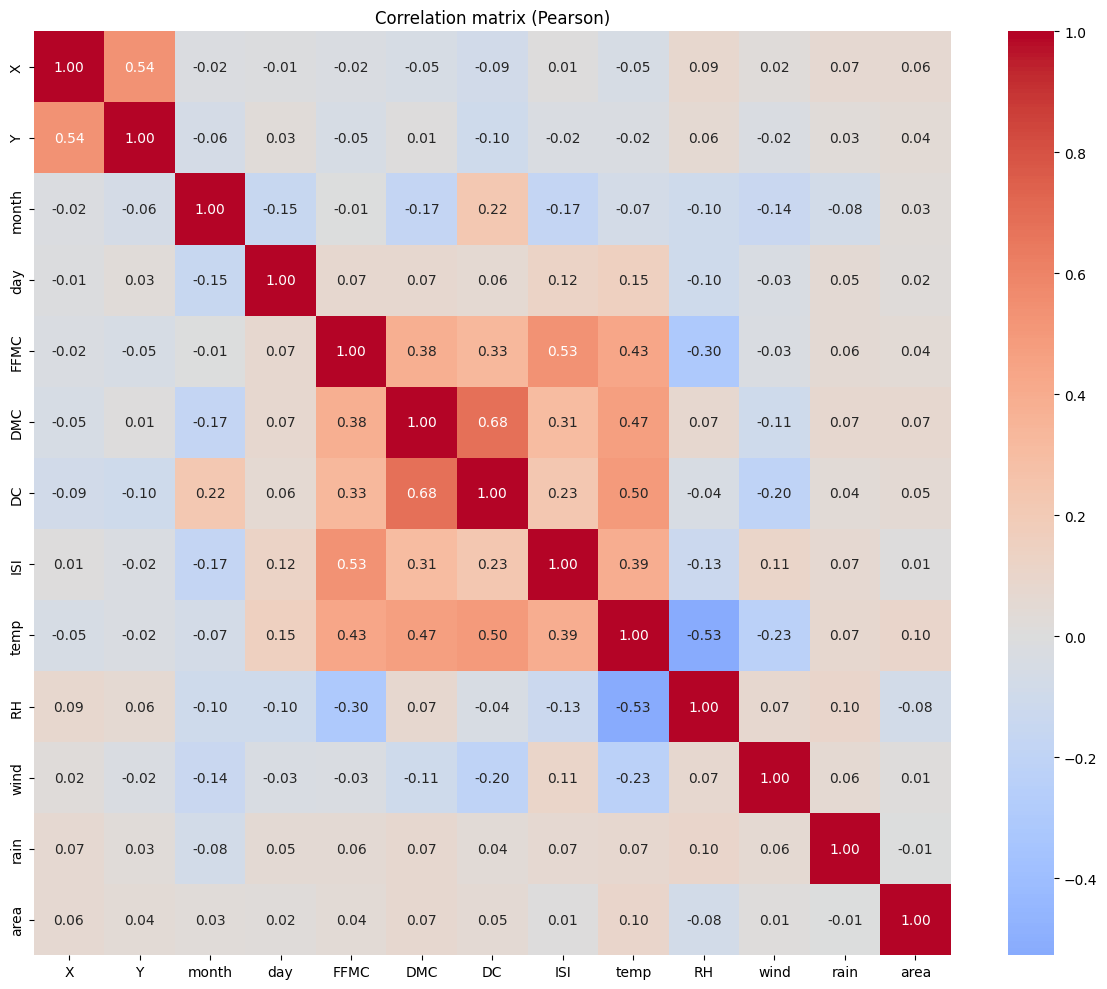

In [43]:
# 2) Корреляционная матрица (Пирсон) и тепловая карта
corr = df_num.corr(method='pearson')
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation matrix (Pearson)')
plt.tight_layout()
plt.show()

Top features by |corr with target|: ['temp', 'RH', 'DMC', 'X', 'DC', 'Y', 'FFMC', 'month']


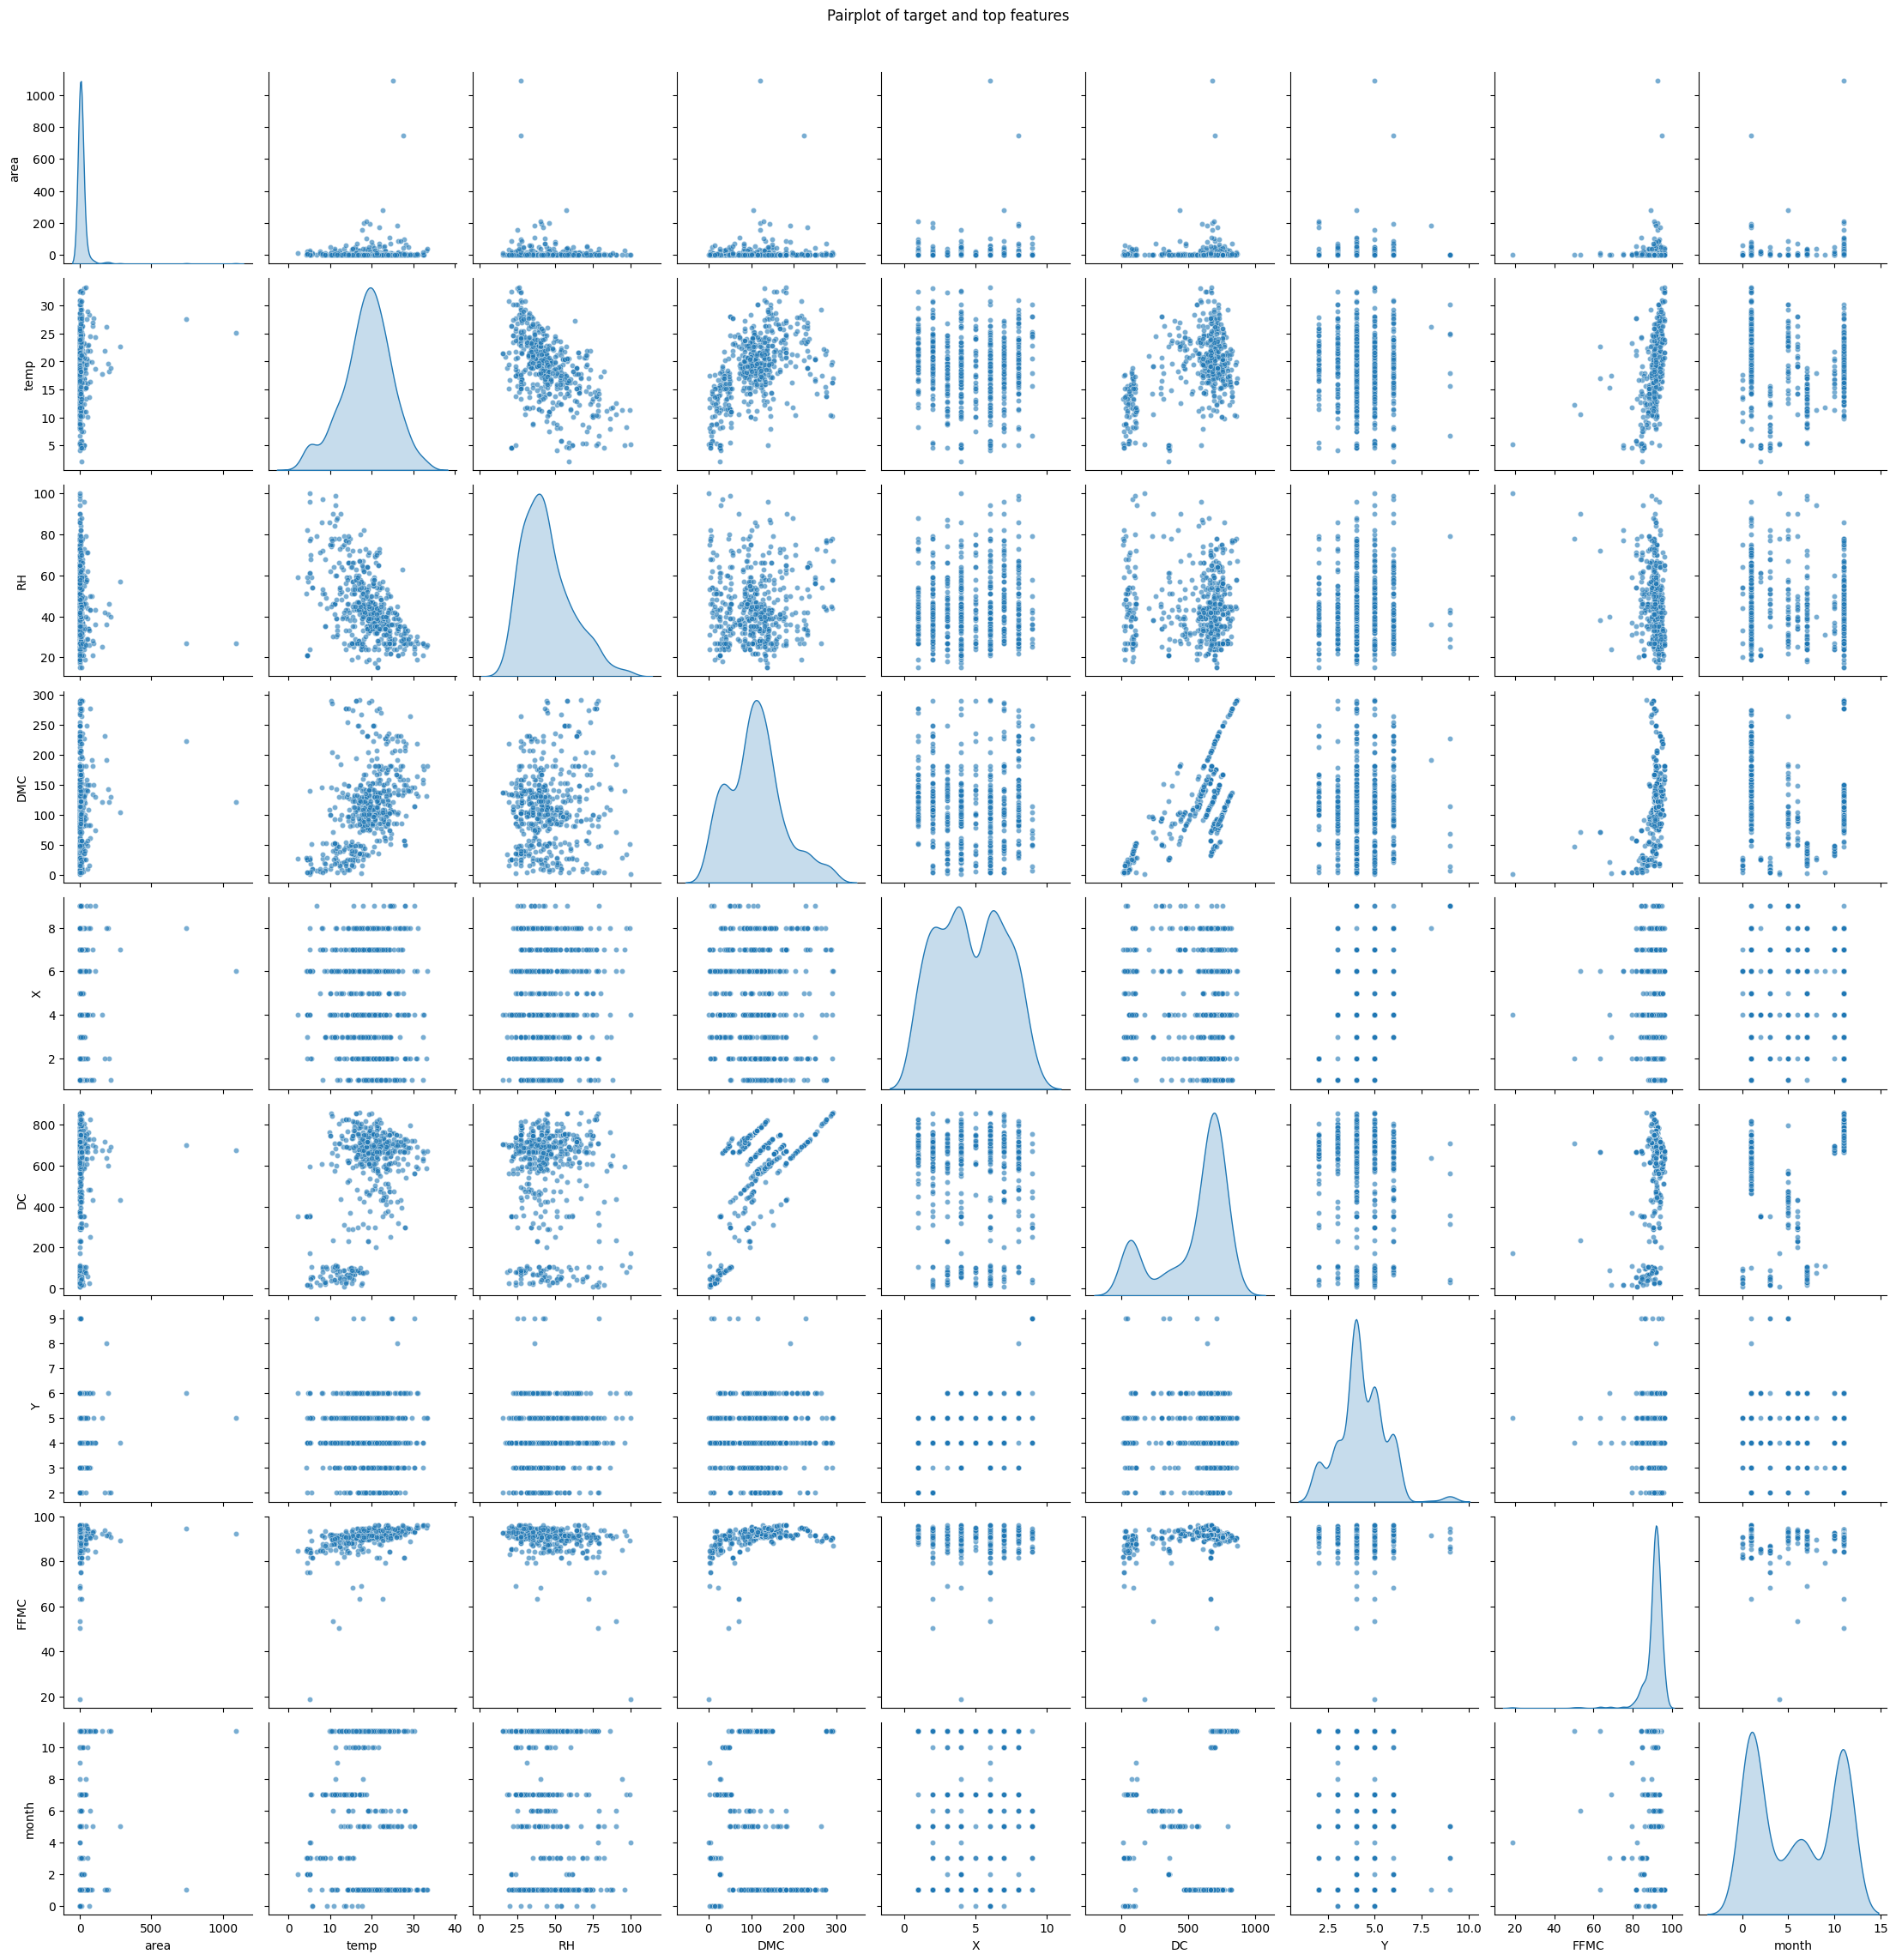

In [ ]:
# 3) Scatterplots: pairplot для поднабора признаков
top_k = 8
corr_with_target = corr[target].abs().sort_values(ascending=False).drop(target)
top_features = corr_with_target.head(top_k).index.tolist()
print("Top features by |corr with target|:", top_features)

sns.pairplot(df_num[[target] + top_features], diag_kind='kde', plot_kws={'s':20, 'alpha':0.6})
plt.suptitle('Pairplot of target and top features', y=1.02)
plt.show()

Mutual information with target (desc):
 month    0.115678
DC       0.072501
ISI      0.038459
temp     0.036245
DMC      0.035446
RH       0.026849
FFMC     0.009245
X        0.000000
Y        0.000000
day      0.000000
wind     0.000000
rain     0.000000
dtype: float64


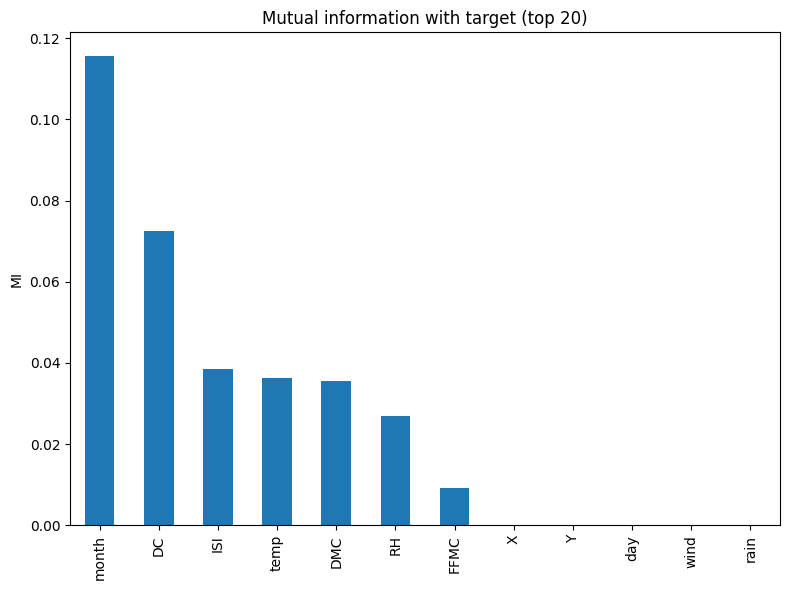

In [45]:
# 4) Нелинейные связи: взаимная информация (для регрессии/классификации)
X = df_num[predictors].copy()
y = df_num[target].copy()
is_classification = pd.api.types.is_integer_dtype(y) and y.nunique() <= 10  # простая эвристика
if is_classification:
    mi = mutual_info_classif(X, y, discrete_features='auto', random_state=0)
else:
    mi = mutual_info_regression(X, y, discrete_features='auto', random_state=0)
mi_series = pd.Series(mi, index=X.columns).sort_values(ascending=False)
print("Mutual information with target (desc):\n", mi_series.head(20))

# Визуализация MI
plt.figure(figsize=(8,6))
mi_series.head(20).plot(kind='bar')
plt.title('Mutual information with target (top 20)')
plt.ylabel('MI')
plt.tight_layout()
plt.show()

In [46]:
# 5) Multicollinearity: VIF
# VIF требует добавления константы; используем только числовые предикторы
X_vif = X.copy().astype(float).fillna(0)
# Добавим константу для statsmodels (не влияет на VIF вычисления значений predictors)
X_vif_const = sm.add_constant(X_vif)
vif_data = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif_const.values, i+1)  # +1 т.к. 0 — константа
            for i in range(len(X_vif.columns))]
}).sort_values('VIF', ascending=False)

print("VIF values:\n", vif_data)

VIF values:
    feature       VIF
6       DC  2.769188
8     temp  2.766729
5      DMC  2.715938
9       RH  1.960343
4     FFMC  1.711713
7      ISI  1.609213
2    month  1.468514
1        Y  1.448213
0        X  1.434815
10    wind  1.155924
3      day  1.059148
11    rain  1.050768


In [47]:
# 6) Рекомендации по снижению мультиколлинеарности (автоматический простой loop)
# Удалять поочередно признаки с VIF > threshold
def reduce_vif(X, thresh=10.0, verbose=True):
    X = X.copy().astype(float).fillna(0)
    while True:
        X_const = sm.add_constant(X)
        vif = pd.Series(
            [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))],
            index=X.columns
        )
        max_vif = vif.max()
        if verbose:
            print("max VIF:", max_vif, "feature:", vif.idxmax())
        if max_vif <= thresh:
            break
        # удалить признак с наибольшим VIF
        X = X.drop(columns=[vif.idxmax()])
    return X.columns.tolist(), vif.sort_values(ascending=False)

reduced_features, final_vif = reduce_vif(X_vif, thresh=10.0, verbose=True)
print("Selected features after VIF reduction:", reduced_features)
print("Final VIF:\n", final_vif)

max VIF: 2.7691881321980643 feature: DC
Selected features after VIF reduction: ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain']
Final VIF:
 DC       2.769188
temp     2.766729
DMC      2.715938
RH       1.960343
FFMC     1.711713
ISI      1.609213
month    1.468514
Y        1.448213
X        1.434815
wind     1.155924
day      1.059148
rain     1.050768
dtype: float64


## Task 2

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import umap        # pip install umap-learn
from scipy.cluster.hierarchy import dendrogram, linkage

# Parameters
target = 'area'
predictors = [c for c in df_le.columns if c != target]

# 0) Preprocessing: separate numeric and categorical, simple imputation + encoding
num_cols = df_le[predictors].select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in predictors if c not in num_cols]

num_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

if cat_cols:
    cat_pipeline = Pipeline([
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])
    preproc = ColumnTransformer([
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ], remainder='drop')
else:
    preproc = ColumnTransformer([
        ('num', num_pipeline, num_cols)
    ])

X = preproc.fit_transform(df_le[predictors].fillna(method='ffill').fillna(0))
feature_names_num = num_cols
if cat_cols:
    ohe = preproc.named_transformers_['cat'].named_steps['onehot']
    ohe_names = ohe.get_feature_names_out(cat_cols)
    feature_names = list(feature_names_num) + list(ohe_names)
else:
    feature_names = feature_names_num

/var/folders/_8/ttfx7gm15n5006bldtscgg_h0000gn/T/ipykernel_27384/1004720168.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = preproc.fit_transform(df_le[predictors].fillna(method='ffill').fillna(0))


PCA: cumulative explained variance: [0.24082186 0.37497926 0.48951492 0.59851952 0.68593777 0.76450405
 0.83196718 0.88954857 0.92815808 0.96520054]


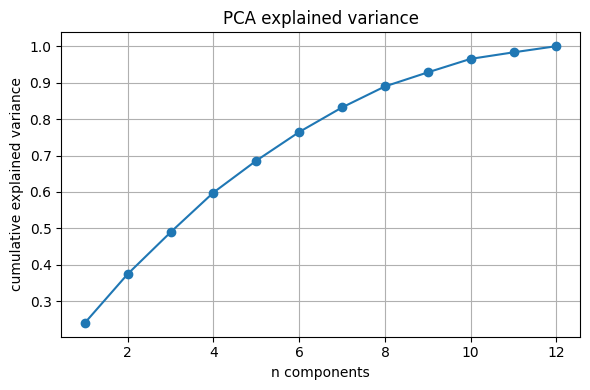

/var/folders/_8/ttfx7gm15n5006bldtscgg_h0000gn/T/ipykernel_27384/4293485837.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], palette='tab10', s=30, alpha=0.7)


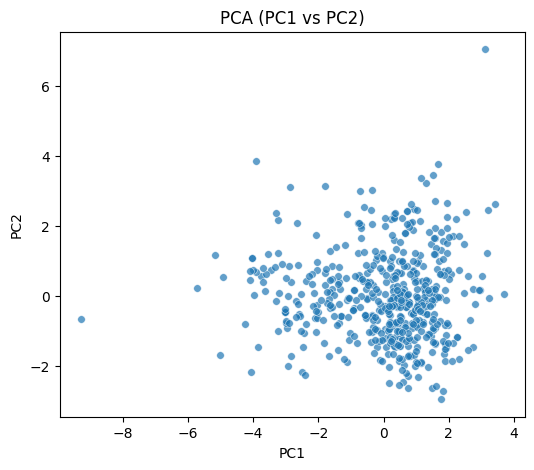

In [ ]:
# 1) PCA
n_pca = min(20, X.shape[1])
pca = PCA(n_components=n_pca, random_state=0)
X_pca = pca.fit_transform(X)
explained = np.cumsum(pca.explained_variance_ratio_)

print("PCA: cumulative explained variance:", explained[:10])
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, n_pca+1), explained, marker='o')
plt.xlabel('n components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.title('PCA explained variance')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,5))
if target in df_le.columns:
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], palette='tab10', s=30, alpha=0.7)
else:
    plt.scatter(X_pca[:,0], X_pca[:,1], s=10, alpha=0.6)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('PCA (PC1 vs PC2)')
plt.show()

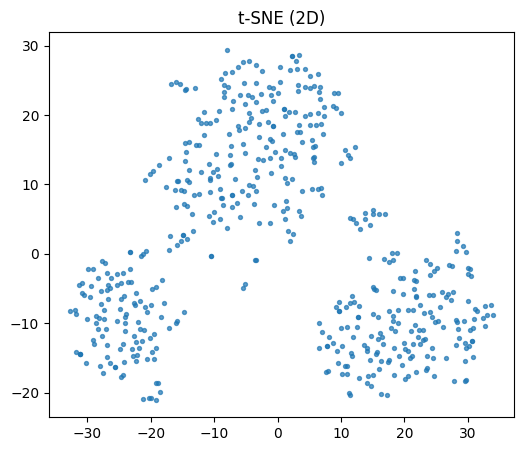

In [50]:
# 2) t-SNE (for visualization; subsample if large)
tsne_sample = 2000
idx = np.random.choice(X.shape[0], min(tsne_sample, X.shape[0]), replace=False)
X_sub = X[idx]

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_sub)
plt.figure(figsize=(6,5))
plt.scatter(X_tsne[:,0], X_tsne[:,1], s=8, alpha=0.7)
plt.title('t-SNE (2D)')
plt.show()

/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


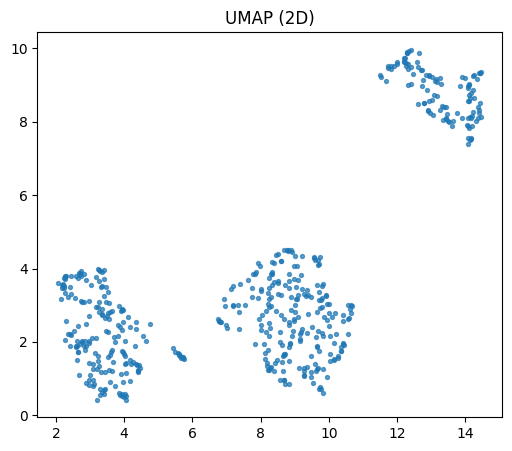

In [51]:
# 3) UMAP (faster, preserves local structure)
reducer = umap.UMAP(n_components=2, random_state=0, n_neighbors=15, min_dist=0.1)
X_umap = reducer.fit_transform(X_sub)
plt.figure(figsize=(6,5))
plt.scatter(X_umap[:,0], X_umap[:,1], s=8, alpha=0.7)
plt.title('UMAP (2D)')
plt.show()

In [52]:

# 4) Factor Analysis (latent factors)
n_factors = min(10, X.shape[1])
fa = FactorAnalysis(n_components=n_factors, random_state=0)
X_fa = fa.fit_transform(X)
# Inspect loadings
loadings = pd.DataFrame(fa.components_.T, index=feature_names, columns=[f'Factor{i+1}' for i in range(n_factors)])
print("Top loadings per factor:")
for col in loadings.columns:
    print(col, loadings[col].abs().sort_values(ascending=False).head(5).index.tolist())

Top loadings per factor:
Factor1 ['temp', 'DC', 'DMC', 'FFMC', 'ISI']
Factor2 ['RH', 'DMC', 'temp', 'DC', 'FFMC']
Factor3 ['month', 'ISI', 'Y', 'DC', 'X']
Factor4 ['Y', 'X', 'ISI', 'wind', 'month']
Factor5 ['FFMC', 'month', 'ISI', 'wind', 'temp']
Factor6 ['rain', 'ISI', 'RH', 'wind', 'DMC']
Factor7 ['wind', 'FFMC', 'rain', 'DC', 'X']
Factor8 ['rain', 'ISI', 'FFMC', 'Y', 'DC']
Factor9 ['day', 'temp', 'DC', 'rain', 'month']
Factor10 ['X', 'Y', 'month', 'day', 'DC']


Best KMeans k: 2 silhouette: 0.23953181281958416


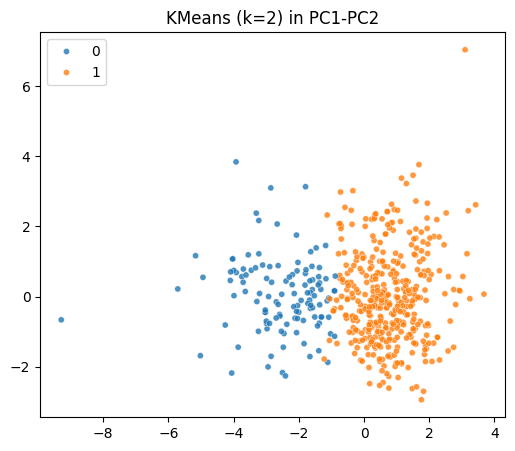

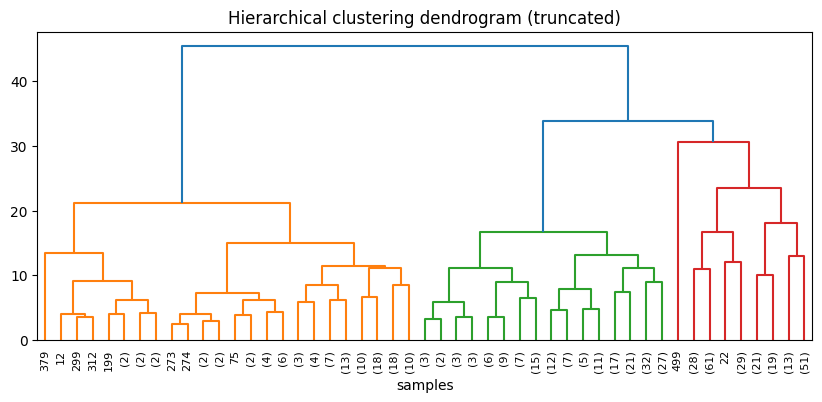

In [ ]:
# 5) Clustering
n_km_feats = min(10, X_pca.shape[1])
X_km = X_pca[:, :n_km_feats]

def best_kmeans(X, kmin=2, kmax=10):
    best_k, best_score, best_model = None, -1, None
    for k in range(kmin, min(kmax, X.shape[0]-1)+1):
        km = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels = km.fit_predict(X)
        score = silhouette_score(X, labels)
        if score > best_score:
            best_score = score; best_k = k; best_model = km
    return best_k, best_score, best_model

k_best, score_best, km_model = best_kmeans(X_km, kmin=2, kmax=10)
print("Best KMeans k:", k_best, "silhouette:", score_best)

labels = km_model.predict(X_km)  # <- совпадающие размеры
plt.figure(figsize=(6,5))
sns.scatterplot(x=X_km[:,0], y=X_km[:,1], hue=labels, palette='tab10', s=20, alpha=0.8)
plt.title(f'KMeans (k={k_best}) in PC1-PC2')
plt.show()

Z = linkage(X_km[:, :min(10, X_km.shape[1])], method='ward')
plt.figure(figsize=(10,4))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical clustering dendrogram (truncated)')
plt.xlabel('samples')
plt.show()

In [54]:
# 6) Optionally: attach cluster labels to df_le
df_le['kmeans_cluster'] = km_model.predict(X_pca[:, :min(10, X_pca.shape[1])])


## Task 3

In [55]:
from sklearn.preprocessing import PolynomialFeatures, KBinsDiscretizer, StandardScaler
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

# Настройки
target = 'area'
predictors = [c for c in df_le.columns if c != target]
# Рабочие матрицы (заполнить/кодировать NAN/категории заранее)
df_work = df_le[predictors + [target]].copy().fillna(0)

# Разделение на X, y
X = df_work[predictors].copy()
y = df_work[target].copy()

# Стандартизируем числовые признаки (рекомендуется перед полиномами/взаимодействиями)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

In [62]:
# 1) Feature Interaction Generation (ручные и автоматические)
# 1a. Ручная: пример взаимодействия X1 * X2
X_scaled['month_area'] = X_scaled['month'] * X_scaled['temp']  # замените X1/X2 на реальные столбцы

# 1b. Автоматическая генерация всех попарных взаимодействий (включая квадраты по желанию)
poly_inter = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_inter = pd.DataFrame(poly_inter.fit_transform(X_scaled), 
                       columns=poly_inter.get_feature_names_out(X_scaled.columns),
                       index=X_scaled.index)


In [59]:
# 2) Polynomial Features (включая квадраты и перекрёстные термы)
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = pd.DataFrame(poly.fit_transform(X_scaled),
                      columns=poly.get_feature_names_out(X_scaled.columns),
                      index=X_scaled.index)

In [63]:
# 3) Binning / Discretization
# Квантильные бинны (например 5)
kbd = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
X_binned = pd.DataFrame(kbd.fit_transform(X[['month']]),
                        columns=[f"{'month'}_bin"], index=X.index)

# Создание биннов для многих колонок
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
kbd_all = KBinsDiscretizer(n_bins=5, encode='onehot-dense', strategy='quantile')
X_binned_all = pd.DataFrame(kbd_all.fit_transform(X[num_cols]),
                            columns=kbd_all.get_feature_names_out(num_cols), index=X.index)

/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:396: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(
/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight

In [58]:
# 4) Feature Selection Techniques
# 4a. Lasso (регуляризация) — автоматическое отбрасывание малозначимых признаков
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
lasso = LassoCV(cv=5, random_state=0, n_jobs=-1).fit(X_train, y_train)
coef = pd.Series(lasso.coef_, index=X_scaled.columns).sort_values(key=lambda s: s.abs(), ascending=False)
print("Top Lasso features:\n", coef.head(20))
selected_by_lasso = coef[coef.abs() > 1e-6].index.tolist()

# 4b. Recursive Feature Elimination (RFE) с базовой моделью (пример для регрессии)
est = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=-1)
n_select = min(20, X_scaled.shape[1])
rfe = RFE(estimator=est, n_features_to_select=n_select, step=0.1).fit(X_train, y_train)
rfe_selected = X_scaled.columns[rfe.support_].tolist()
print("RFE selected:", rfe_selected)

# 4c. Важности признаков из дерева (простая и быстрая оценка)
rf = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1).fit(X_train, y_train)
imp = pd.Series(rf.feature_importances_, index=X_scaled.columns).sort_values(ascending=False)
print("Top feature importances (RF):\n", imp.head(20))

Top Lasso features:
 X                 0.0
Y                 0.0
month             0.0
day               0.0
FFMC              0.0
DMC               0.0
DC                0.0
ISI               0.0
temp              0.0
RH                0.0
wind              0.0
rain              0.0
kmeans_cluster    0.0
dtype: float64
RFE selected: ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain', 'kmeans_cluster']
Top feature importances (RF):
 DMC               0.301646
temp              0.255132
RH                0.077606
DC                0.069376
Y                 0.063786
wind              0.050509
FFMC              0.043010
ISI               0.042303
day               0.039441
X                 0.037419
month             0.018983
kmeans_cluster    0.000749
rain              0.000039
dtype: float64


In [60]:
# 5) Комбинации: создать расширенный набор признаков и затем отобрать
# Пример: соединить полиномиальные признаки + важные взаимодействия, затем отбросить по Lasso
X_extended = pd.concat([X_scaled, X_poly.add_prefix('poly_').iloc[:, :50]], axis=1)  # ограничить число poly cols
# переобучаем Lasso на расширенном наборе
X_tr_e, X_val_e, y_tr, y_val = train_test_split(X_extended, y, test_size=0.2, random_state=0)
lasso_e = LassoCV(cv=5, random_state=0, n_jobs=-1).fit(X_tr_e, y_tr)
coef_e = pd.Series(lasso_e.coef_, index=X_extended.columns)
selected_ext = coef_e[coef_e.abs() > 1e-6].index.tolist()
print("Selected from extended set:", len(selected_ext))

Selected from extended set: 0


/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e+02, tolerance: 7.782e+01
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.154e+02, tolerance: 7.782e+01
  model = cd_fast.enet_coordinate_descent_gram(
/Users/anasenicenkova/mmsa_labs/.venv/lib/python3.14/site-packages/sklearn/linear_model/_coordinate_descent.py:701: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of th